### Imports

In [ ]:
!pip install tensorflow mediapipe keras tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 64.0 MB/s eta 0:00:00


In [ ]:
pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling1D, LSTM, TimeDistributed, LayerNormalization, MultiHeadAttention, Add, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import h5py
import matplotlib.pyplot as plt

### GPU enabling

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        try:
            tf.config.experimental.set_memory_growth(device, True)
            tf.config.set_logical_device_configuration(
                device, [tf.config.LogicalDeviceConfiguration(memory_limit=13000)]
            )
            print("Configured GPU with a memory limit of 13000 MB.")
        except Exception as e:
            print(f"Error configuring GPU: {e}")
else:
    print("No GPU detected, running on CPU.")

try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled for speedup.")
except ValueError:
    print("Mixed precision not supported, running with default precision.")

Configured GPU with a memory limit of 13000 MB.
Mixed precision enabled for speedup.


### Standardization

In [ ]:
def standardize_features(input_file, output_file):
    with h5py.File(input_file, "r") as input_h5, h5py.File(output_file, "w") as output_h5:
        keys = list(input_h5.keys())
        print(f"Found {len(keys)} features in the input file.")

        for key in tqdm(keys, desc="Standardizing Keys", unit="key"):
            features = input_h5[key][:]
            mean = np.mean(features, axis=0)
            std = np.std(features, axis=0)
            std[std == 0] = 1
            standardized_features = (features - mean) / std
            output_h5.create_dataset(key, data=standardized_features)

input_file_path = "drive/MyDrive/final_dataset/features/fused/fused_features_padded.h5"
output_file_path = "drive/MyDrive/final_dataset/features/fused/fused_features_standardized.h5"
standardize_features(input_file_path, output_file_path)

Found 2 features in the input file.


Standardizing Keys: 100%|██████████| 2/2 [00:14<00:00,  7.13s/key]


### TransformerBlock

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Loading the dataset

In [ ]:
data_path = 'drive/MyDrive/final_dataset/features/fused/fused_features_standardized.h5'
try:
    print("Loading fused features...")
    with h5py.File(data_path, 'r') as h5_file:
        if 'fused_real_features' in h5_file and 'fused_fake_features' in h5_file:
            data = np.array(h5_file['fused_real_features'])
            data_fake = np.array(h5_file['fused_fake_features'])
            print("Features loaded successfully.")
        else:
            raise KeyError("Dataset keys not found in HDF5 file.")
except OSError as e:
    print(f"Error opening HDF5 file: {e}")
    raise
except KeyError as e:
    print(f"Error accessing datasets: {e}")
    raise

fused_features = np.concatenate([data[:], data_fake[:]], axis=0)
labels = np.concatenate([np.ones(len(data)), np.zeros(len(data_fake))], axis=0)


Loading fused features...
Features loaded successfully.


### preprocessing

In [ ]:
def preprocess_data(features, labels, target_height=224, target_width=224):
    print("Preprocessing data...")
    features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)

    if len(features_tensor.shape) == 3:
        features_tensor = tf.expand_dims(features_tensor, axis=-1)

    features_resized = tf.image.resize(features_tensor, [target_height, target_width])

    if features_resized.shape[-1] == 1:
        features_resized = tf.image.grayscale_to_rgb(features_resized)

    return features_resized, labels

### Cross validation

Starting Fold 1
Preprocessing data...
Preprocessing data...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.7678 - auc: 0.8231 - loss: 0.5530
Epoch 1: val_loss improved from inf to 0.98366, saving model to drive/MyDrive/final_dataset/checkpoints/fold_1_checkpoint.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7699 - auc: 0.8256 - loss: 0.5480 - val_accuracy: 0.5271 - val_auc: 0.5231 - val_loss: 0.9837 - learning_rate: 1.0000e-05
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9950 - auc: 0.9998 - loss: 0.0314
Epoch 2: val_loss did not improve from 0.98366
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9949 - auc: 0.9998 - loss: 0.0314 - val_accuracy: 0.5271 - val_auc: 0.8961 - val_loss: 1.7577 - learning_rate: 1.0000e-05
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 0.0070
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999

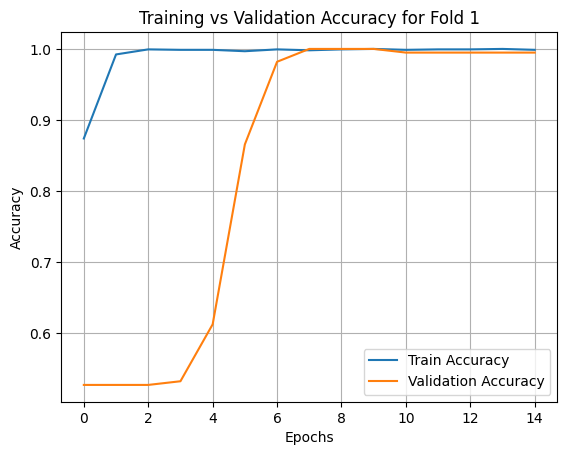

Starting Fold 2
Preprocessing data...
Preprocessing data...
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6650 - auc_1: 0.7010 - loss: 0.7798
Epoch 1: val_loss improved from inf to 0.82697, saving model to drive/MyDrive/final_dataset/checkpoints/fold_2_checkpoint.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.6681 - auc_1: 0.7051 - loss: 0.7725 - val_accuracy: 0.5220 - val_auc_1: 0.7226 - val_loss: 0.8270 - learning_rate: 1.0000e-05
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9763 - auc_1: 0.9974 - loss: 0.0636
Epoch 2: val_loss did not improve from 0.82697
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9764 - auc_1: 0.9974 - loss: 0.0633 - val_accuracy: 0.5220 - val_auc_1: 0.8468 - val_loss: 1.3465 - learning_rate: 1.0000e-05
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9985 - auc_1: 1.0000 - loss: 0.0162 
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 3: val_loss

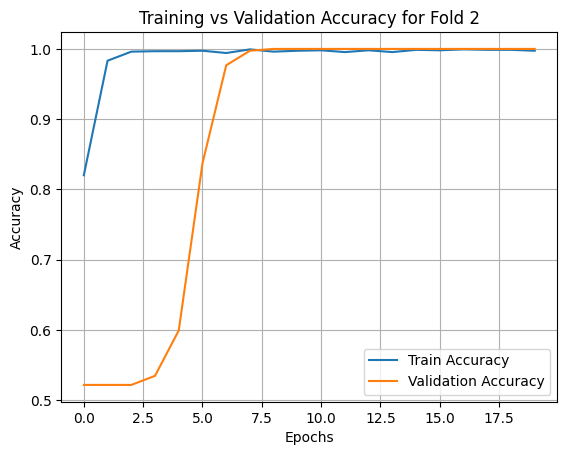

Starting Fold 3
Preprocessing data...
Preprocessing data...
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7203 - auc_2: 0.7811 - loss: 0.6230
Epoch 1: val_loss improved from inf to 1.41972, saving model to drive/MyDrive/final_dataset/checkpoints/fold_3_checkpoint.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7228 - auc_2: 0.7841 - loss: 0.6174 - val_accuracy: 0.4806 - val_auc_2: 0.1779 - val_loss: 1.4197 - learning_rate: 1.0000e-05
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9900 - auc_2: 0.9995 - loss: 0.0435
Epoch 2: val_loss did not improve from 1.41972
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9900 - auc_2: 0.9995 - loss: 0.0434 - val_accuracy: 0.4806 - val_auc_2: 0.5188 - val_loss: 1.7029 - learning_rate: 1.0000e-05
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9979 - auc_2: 1.0000 - loss: 0.0144 
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 3: val_loss

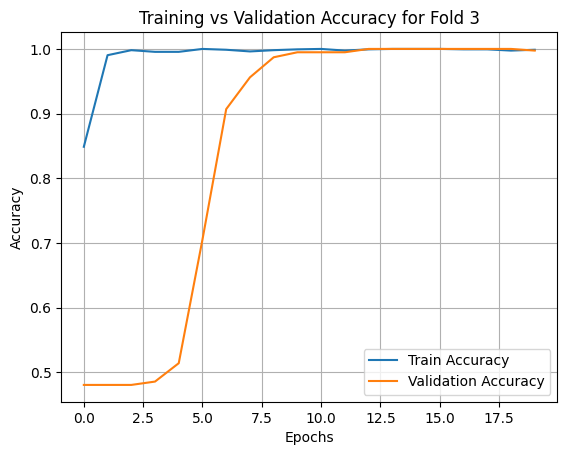

Starting Fold 4
Preprocessing data...
Preprocessing data...
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7789 - auc_3: 0.8587 - loss: 0.4836
Epoch 1: val_loss improved from inf to 1.27973, saving model to drive/MyDrive/final_dataset/checkpoints/fold_4_checkpoint.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7807 - auc_3: 0.8605 - loss: 0.4799 - val_accuracy: 0.5013 - val_auc_3: 0.2304 - val_loss: 1.2797 - learning_rate: 1.0000e-05
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9850 - auc_3: 0.9987 - loss: 0.0523
Epoch 2: val_loss did not improve from 1.27973
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9851 - auc_3: 0.9987 - loss: 0.0521 - val_accuracy: 0.5013 - val_auc_3: 0.9273 - val_loss: 1.7039 - learning_rate: 1.0000e-05
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9894 - auc_3: 0.9996 - loss: 0.0280
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 3: val_loss

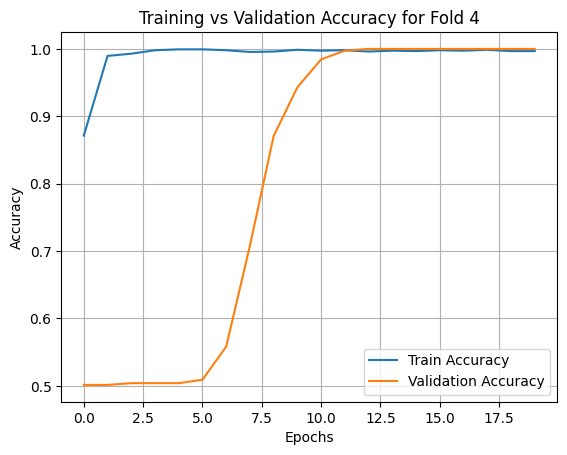

Starting Fold 5
Preprocessing data...
Preprocessing data...
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.6607 - auc_4: 0.7199 - loss: 0.7681
Epoch 1: val_loss improved from inf to 0.88656, saving model to drive/MyDrive/final_dataset/checkpoints/fold_5_checkpoint.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6639 - auc_4: 0.7236 - loss: 0.7610 - val_accuracy: 0.4819 - val_auc_4: 0.4774 - val_loss: 0.8866 - learning_rate: 1.0000e-05
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9887 - auc_4: 0.9991 - loss: 0.0481
Epoch 2: val_loss did not improve from 0.88656
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9886 - auc_4: 0.9991 - loss: 0.0481 - val_accuracy: 0.4767 - val_auc_4: 0.8029 - val_loss: 2.0501 - learning_rate: 1.0000e-05
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9987 - auc_4: 1.0000 - loss: 0.0109
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 3: val_loss 

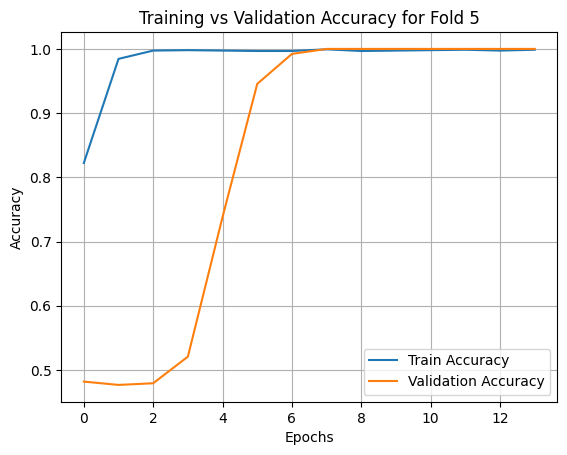

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=25)
batch_size = 32
epochs = 20
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(fused_features)):
    print(f"Starting Fold {fold + 1}")
    X_train, X_val = fused_features[train_idx], fused_features[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train_resized, y_train = preprocess_data(X_train, y_train)
    X_val_resized, y_val = preprocess_data(X_val, y_val)

    input_layer = Input(shape=(224, 224, 3))
    resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

    x = GlobalAveragePooling2D()(resnet_base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Reshape((1, -1))(x)
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = LSTM(128, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = TransformerBlock(embed_dim=128, num_heads=8, ff_dim=128)(x, training=True)

    x = GlobalAveragePooling2D()(resnet_base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    output_layer = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    checkpoint_path = f'drive/MyDrive/final_dataset/checkpoints/fold_{fold + 1}_checkpoint.weights.h5'
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1
    )

    history = model.fit(
        X_train_resized, y_train,
        validation_data=(X_val_resized, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
            checkpoint_callback
        ]
    )

    print("Evaluating the model...")
    eval_metrics = model.evaluate(X_val_resized, y_val, batch_size=batch_size, verbose=1)
    y_pred_prob = model.predict(X_val_resized, batch_size=batch_size, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    fold_results.append({
        'fold': fold + 1,
        'loss': eval_metrics[0],
        'accuracy': eval_metrics[1],
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs Validation Accuracy for Fold {fold + 1}')
    plt.legend()
    plt.grid()
    plt.show()


### Save the model


In [ ]:
print("Saving the model...")
model.save('drive/MyDrive/final_dataset/final_dfd_model.keras')

Saving the model...


### Evaluation

In [ ]:
print("Evaluating the model...")
eval_metrics = model.evaluate(
    X_val_resized, 
    y_val,  
    batch_size=batch_size,
    verbose=1  
)
print(f"Validation Loss: {eval_metrics[0]}, Validation Accuracy: {eval_metrics[1]}")


Evaluating the model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - auc_4: 0.5714 - loss: 0.0088
Validation Loss: 0.007565200794488192, Validation Accuracy: 1.0


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

print("Generating predictions on the validation set...")
y_pred_prob = model.predict(X_val_resized, batch_size=batch_size, verbose=1)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (threshold = 0.5)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

conf_matrix = confusion_matrix(y_val, y_pred)

class_report = classification_report(y_val, y_pred, target_names=["Fake", "Real"])

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


Generating predictions on the validation set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Evaluation Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Confusion Matrix:
[[183   0]
 [  0 203]]

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       183
        Real       1.00      1.00      1.00       203

    accuracy                           1.00       386
   macro avg       1.00      1.00      1.00       386
weighted avg       1.00      1.00      1.00       386



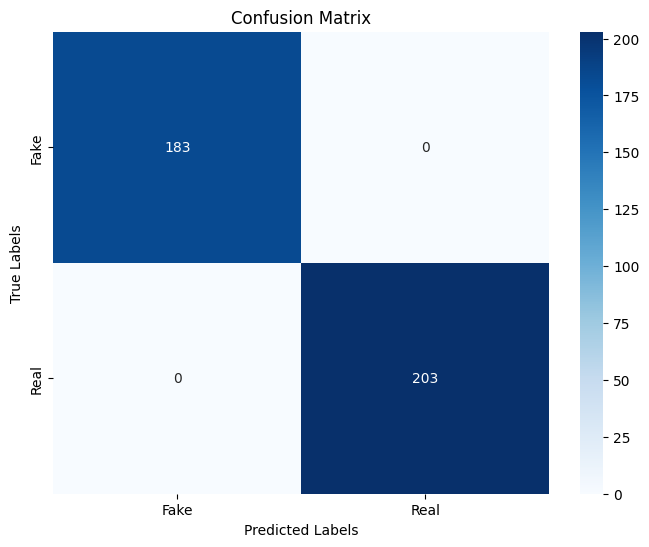

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Fake", "Real"]
plot_confusion_matrix(conf_matrix, class_names)


### Visualize metrics

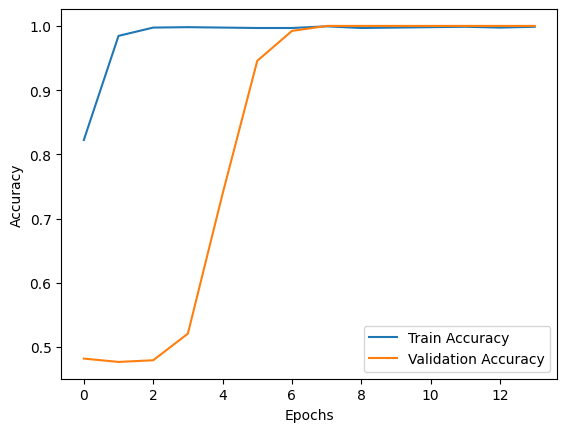

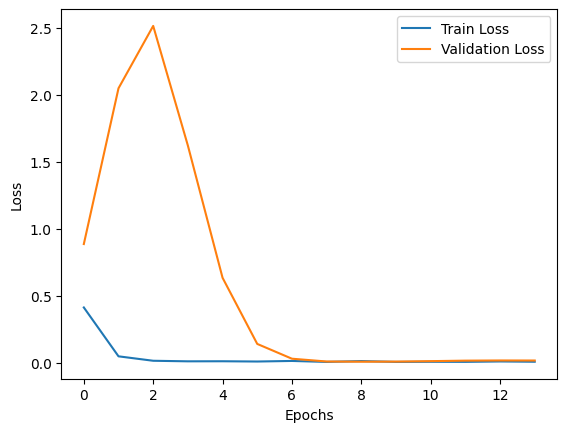

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

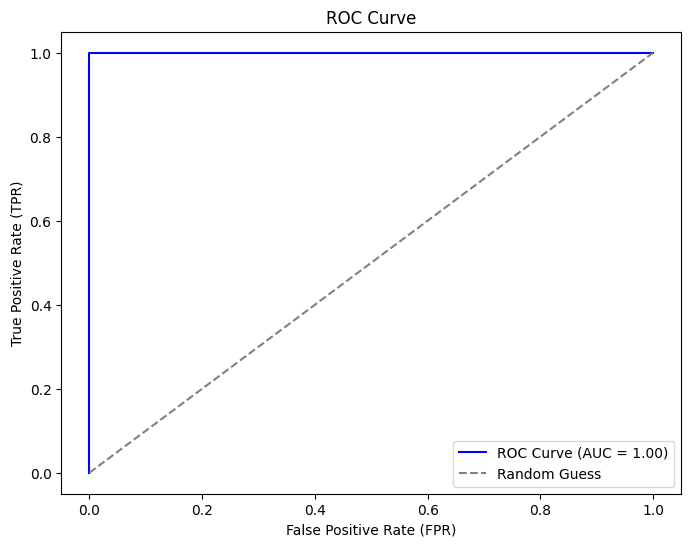

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


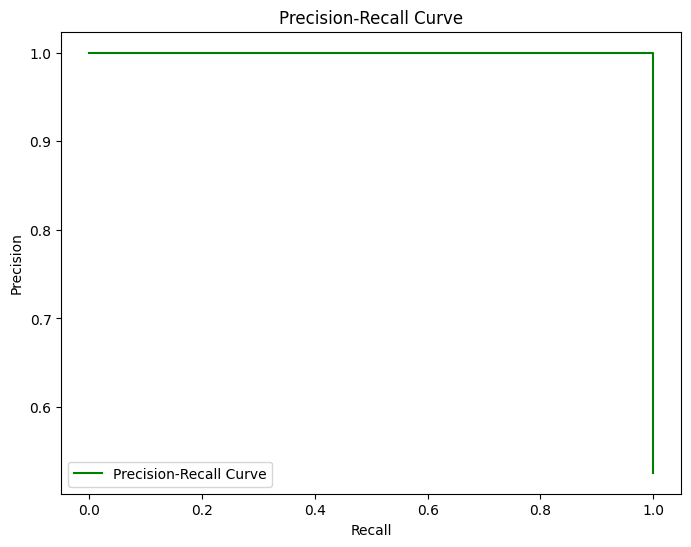

In [ ]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


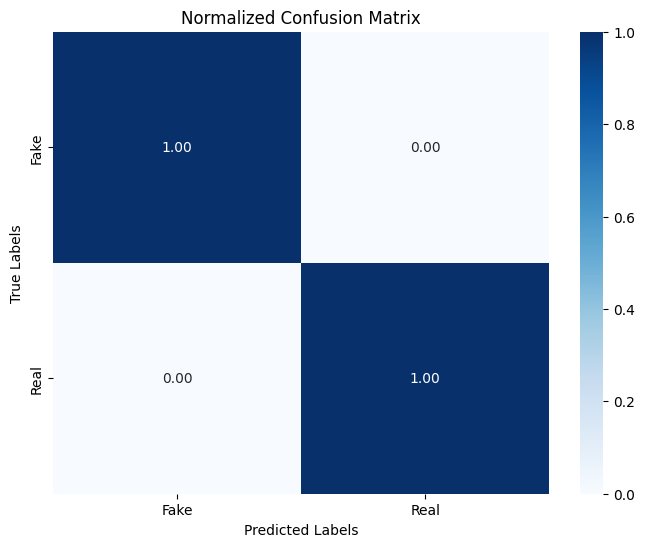

In [ ]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


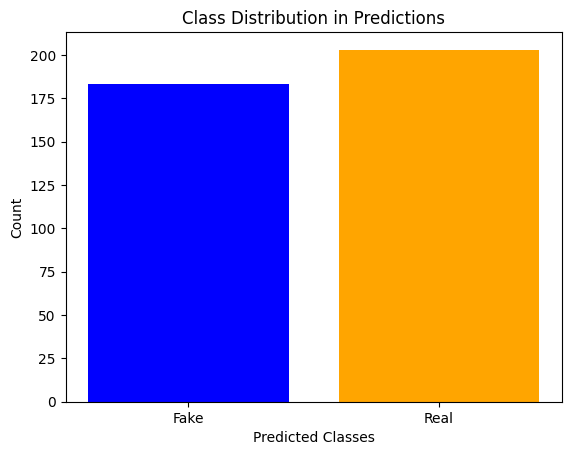

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
plt.bar(unique, counts, color=['blue', 'orange'])
plt.xticks([0, 1], class_names)
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Predictions')
plt.show()


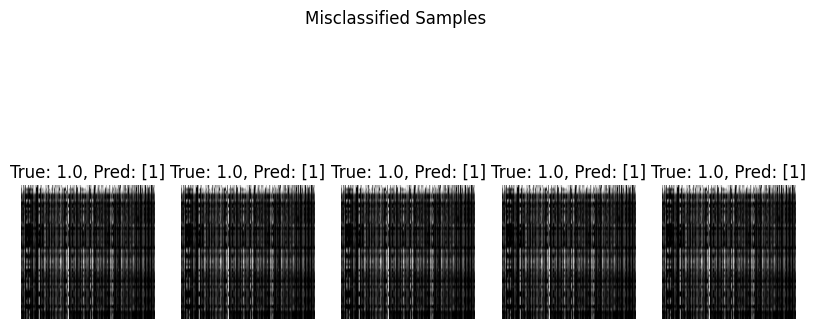

In [ ]:
misclassified_indices = np.where(y_pred != y_val)[0]

plt.figure(figsize=(10, 5))
for i, idx in enumerate(misclassified_indices[:5]):  
    plt.subplot(1, 5, i+1)
    plt.imshow(X_val_resized[idx])  
    plt.title(f'True: {y_val[idx]}, Pred: {y_pred[idx]}')
    plt.axis('off')
plt.suptitle('Misclassified Samples')
plt.show()


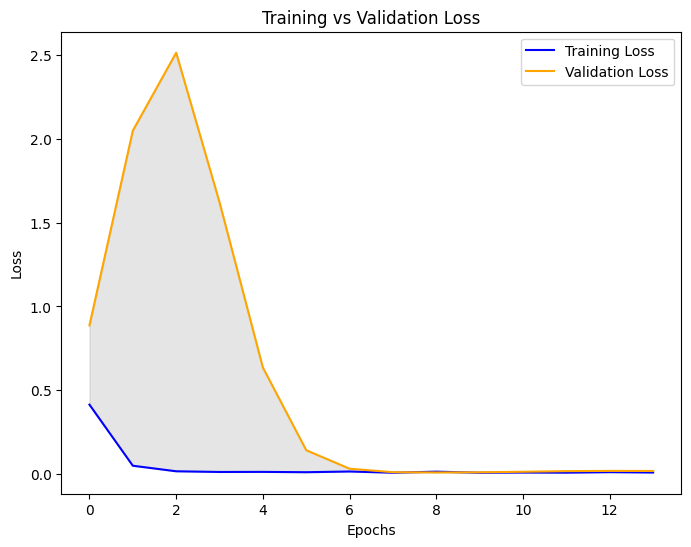

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.fill_between(range(len(history.history['loss'])),
                 history.history['loss'], history.history['val_loss'], color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


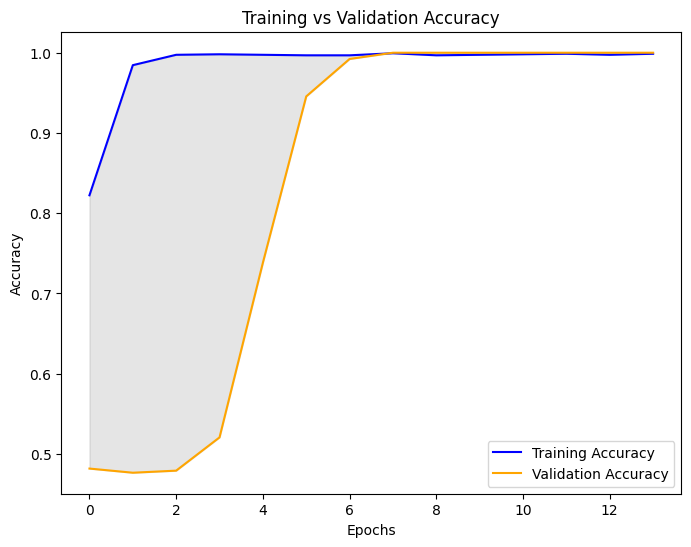

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.fill_between(range(len(history.history['accuracy'])),
                 history.history['accuracy'], history.history['val_accuracy'], color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()
